In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.font_manager as fm 
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc' 
font = fm.FontProperties(fname=font_path).get_name() 
matplotlib.rc('font', family=font) 

In [31]:
# 데이터 로드
df = pd.read_csv('../eda/data/merged_data.csv')

df = df.drop('폐업_점포_수', axis=1)

In [32]:
# 입력-타겟 데이터 분리
X = df.drop('폐업_률', axis=1)
y = df['폐업_률']

In [33]:
# 범주형 데이터 인코딩
from sklearn.preprocessing import OneHotEncoder

# 범주형 컬럼 찾기
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X[categorical_cols])

# 인코딩 결과를 DataFrame으로 변환
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)

# 숫자 변수 + 인코딩된 범주 변수 합치기
X_encoded = pd.concat([X[numerical_cols], encoded_df], axis=1)

In [34]:
# 학습-검증 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, random_state=42)

---

##### 이진분류

In [7]:
# 이진 타겟 생성
threshold = y.median() # 평균보다 높으면 1, 낮으면 0
y_binary = (y > threshold).astype(int)

In [8]:
# 모델 생성
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

y_train_binary, y_valid_binary = train_test_split(y_binary, random_state=42)

# 모델 학습
model.fit(X_train, y_train_binary, eval_set=(X_valid, y_valid_binary), early_stopping_rounds=50)

0:	learn: 0.6902038	test: 0.6852111	best: 0.6852111 (0)	total: 176ms	remaining: 1m 27s
100:	learn: 0.7573797	test: 0.7438463	best: 0.7438463 (100)	total: 2.04s	remaining: 8.05s
200:	learn: 0.7881325	test: 0.7501501	best: 0.7515509 (185)	total: 3.84s	remaining: 5.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7515509306
bestIteration = 185

Shrink model to first 186 iterations.


In [9]:
# 예측 및 평가
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred = model.predict(X_valid)

# 평가
print(classification_report(y_valid_binary, y_pred))
print(confusion_matrix(y_valid_binary, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      5154
           1       0.77      0.70      0.73      4840

    accuracy                           0.75      9994
   macro avg       0.75      0.75      0.75      9994
weighted avg       0.75      0.75      0.75      9994

[[4136 1018]
 [1465 3375]]


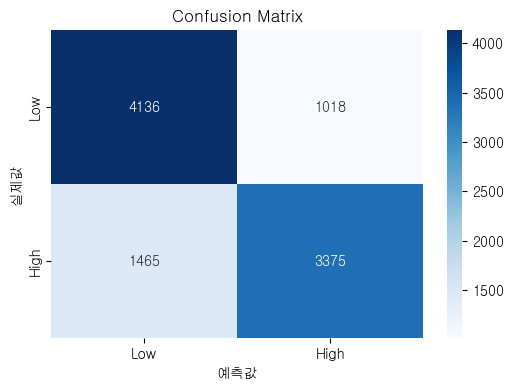

In [10]:
# 혼동 행렬 확인
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid_binary, y_pred)

# 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix')
plt.show()

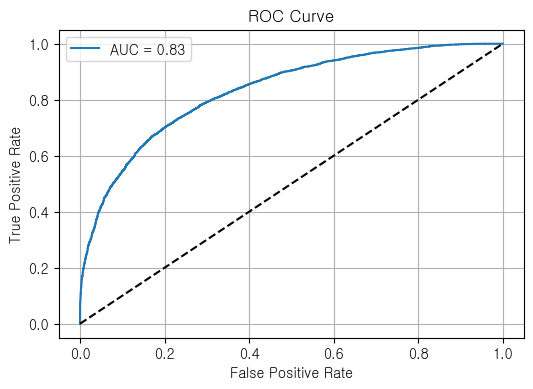

In [11]:
# ROC Curve 확인
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 확률
y_probs = model.predict_proba(X_valid)[:, 1]

# ROC 커브
fpr, tpr, thresholds = roc_curve(y_valid_binary, y_probs)
auc_score = roc_auc_score(y_valid_binary, y_probs)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

---

##### 상위 30% 기준 분류

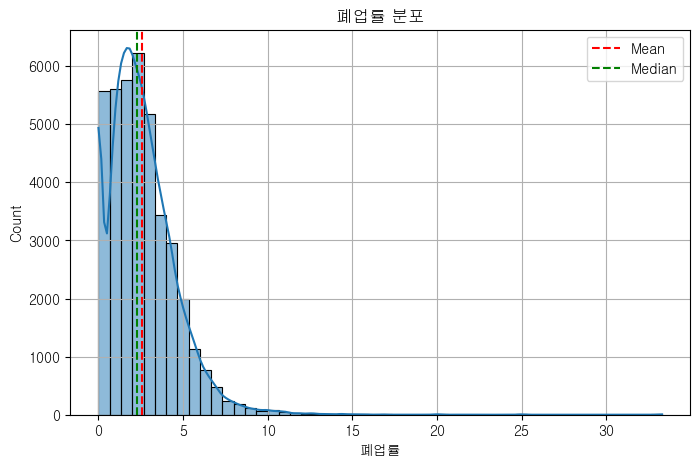

In [16]:
# 폐업률 분포 확인
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=50, kde=True)
plt.axvline(y.mean(), color='r', linestyle='--', label='Mean')
plt.axvline(y.median(), color='g', linestyle='--', label='Median')
plt.title('폐업률 분포')
plt.xlabel('폐업률')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 이진 타겟 생성 (상위 30% 기준)
threshold = y.quantile(0.7)
y_binary = (y > threshold).astype(int)

# 모델 생성
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

y_train_binary, y_valid_binary = train_test_split(y_binary, random_state=42)

# 모델 학습
model.fit(X_train, y_train_binary, eval_set=(X_valid, y_valid_binary), early_stopping_rounds=50)

# 예측
y_pred = model.predict(X_valid)

# 평가
print(classification_report(y_valid_binary, y_pred))
print(confusion_matrix(y_valid_binary, y_pred))

0:	learn: 0.7754578	test: 0.7624575	best: 0.7624575 (0)	total: 19.2ms	remaining: 19.1s
100:	learn: 0.8100130	test: 0.7892736	best: 0.7893736 (96)	total: 1.82s	remaining: 16.2s
200:	learn: 0.8273907	test: 0.7950770	best: 0.7955773 (195)	total: 3.62s	remaining: 14.4s
300:	learn: 0.8422334	test: 0.7972784	best: 0.7976786 (298)	total: 5.4s	remaining: 12.6s
400:	learn: 0.8561422	test: 0.7984791	best: 0.7999800 (391)	total: 7.25s	remaining: 10.8s
500:	learn: 0.8678496	test: 0.8005803	best: 0.8017811 (472)	total: 9.06s	remaining: 9.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8017810686
bestIteration = 472

Shrink model to first 473 iterations.
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      7084
           1       0.71      0.53      0.61      2910

    accuracy                           0.80      9994
   macro avg       0.77      0.72      0.74      9994
weighted avg       0.79      0.80      0.79      9994



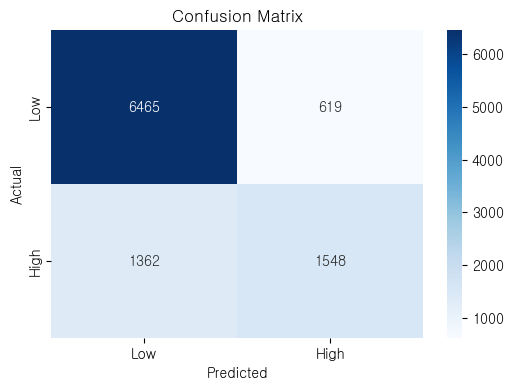

In [ ]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_valid_binary, y_pred)

# 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

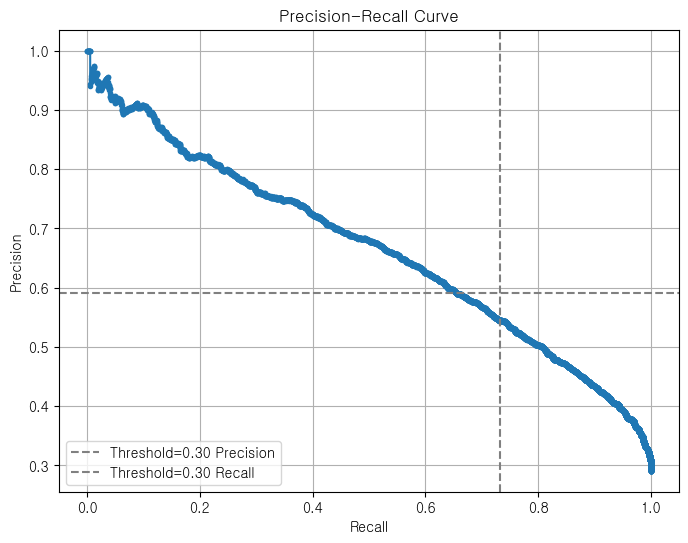

In [19]:
# PR Curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_valid_binary, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axhline(0.591, color='gray', linestyle='--', label='Threshold=0.30 Precision')
plt.axvline(0.732, color='gray', linestyle='--', label='Threshold=0.30 Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

---

##### Threshold 값 조정

In [24]:
# Threshold 조정
# 예측 확률 (class 1만)
y_probs = model.predict_proba(X_valid)[:, 1]

# 성능 비교
thresholds = np.arange(0.1, 0.9, 0.05) 
recalls = []
precisions = []
f1s = []

print("Threshold 테스트 결과:\n")
for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    report = classification_report(y_valid_binary, y_pred_thresh, output_dict=True, zero_division=0)
    
    recall = report['1']['recall']
    precision = report['1']['precision']
    f1 = report['1']['f1-score']
    
    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1)
    
    print(f"Threshold={t:.2f} | Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")

Threshold 테스트 결과:

Threshold=0.10 | Recall: 0.953, Precision: 0.404, F1: 0.568
Threshold=0.15 | Recall: 0.905, Precision: 0.459, F1: 0.609
Threshold=0.20 | Recall: 0.848, Precision: 0.508, F1: 0.635
Threshold=0.25 | Recall: 0.792, Precision: 0.553, F1: 0.651
Threshold=0.30 | Recall: 0.732, Precision: 0.591, F1: 0.654
Threshold=0.35 | Recall: 0.678, Precision: 0.620, F1: 0.648
Threshold=0.40 | Recall: 0.624, Precision: 0.651, F1: 0.637
Threshold=0.45 | Recall: 0.576, Precision: 0.678, F1: 0.623
Threshold=0.50 | Recall: 0.532, Precision: 0.714, F1: 0.610
Threshold=0.55 | Recall: 0.479, Precision: 0.735, F1: 0.580
Threshold=0.60 | Recall: 0.432, Precision: 0.764, F1: 0.552
Threshold=0.65 | Recall: 0.381, Precision: 0.782, F1: 0.512
Threshold=0.70 | Recall: 0.329, Precision: 0.799, F1: 0.466
Threshold=0.75 | Recall: 0.278, Precision: 0.825, F1: 0.416
Threshold=0.80 | Recall: 0.220, Precision: 0.851, F1: 0.349
Threshold=0.85 | Recall: 0.163, Precision: 0.888, F1: 0.275


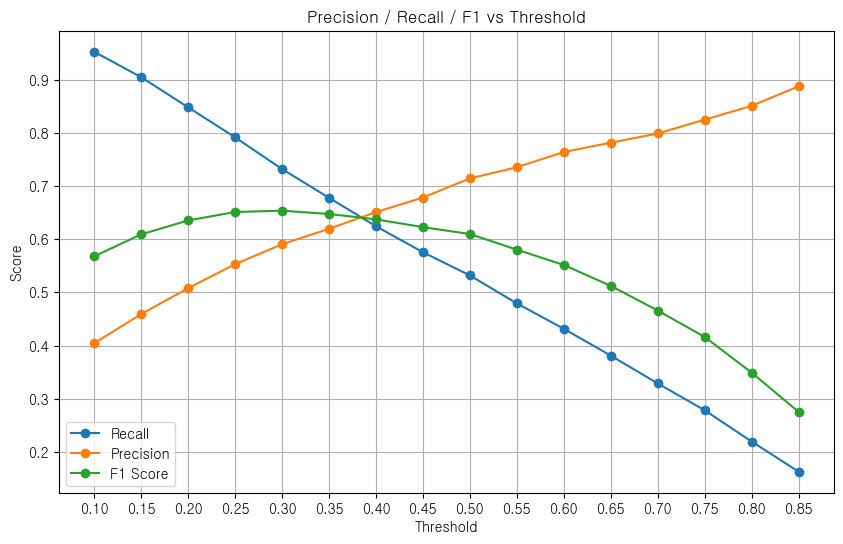

In [25]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / F1 vs Threshold')
plt.grid(True)
plt.legend()
plt.xticks(thresholds)
plt.show()

In [41]:
# 최종 평가
final_threshold = 0.35
y_pred_final = (y_probs >= final_threshold).astype(int)

print(classification_report(y_valid_binary, y_pred_final))
print(confusion_matrix(y_valid_binary, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7084
           1       0.62      0.68      0.65      2910

    accuracy                           0.79      9994
   macro avg       0.74      0.75      0.75      9994
weighted avg       0.79      0.79      0.79      9994

[[6465  619]
 [1362 1548]]


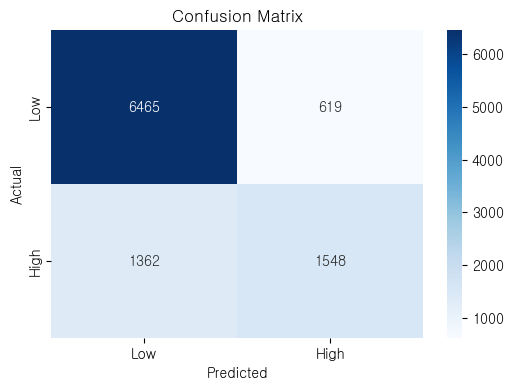

In [42]:
# 혼동 행렬 시각화
y_pred = model.predict(X_valid)

# 혼동 행렬 계산
cm = confusion_matrix(y_valid_binary, y_pred)

# 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

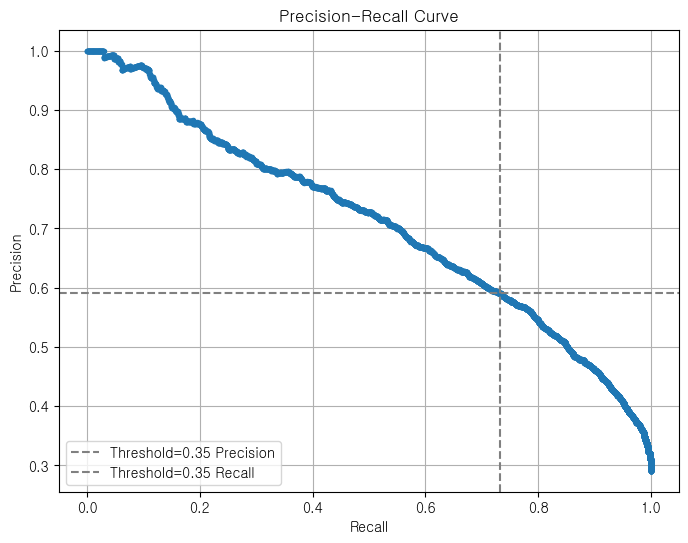

In [44]:
# PR Curve
precision, recall, thresholds = precision_recall_curve(y_valid_binary, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axhline(0.591, color='gray', linestyle='--', label='Threshold=0.35 Precision')
plt.axvline(0.732, color='gray', linestyle='--', label='Threshold=0.35 Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()